# Plotting cross section ratios as a function of Bjorken-x

In [201]:
import uproot, time, sys
start_time = time.time()
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [202]:
folder = 'src'

ntg = 'C12' # What is the nuclei in numerator?
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' # What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' # Aluminium dummy target
dang = 20.0 # What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] # What are your desired central momenta (just the magnitude)
cafe_report_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/reportfiles/'
tinfo_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/HMS_runlist.txt'
bin_num = 32 * len(dmom) # half percent bins according to the resolution of the spectrometer (-8% to 8%)

# Kinematic variables
ts = dang # Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  # Target
thick = target_info[ntg][2] # g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

#Constants
Ei, Mp = 10.54, 0.93825 # Beam energcountsy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 # Avogadro's number and charge in 1 electron
al_den, length = 2.699, 10. # Density of aluminum can and length of can
dpp_up, dpp_down = 15.0, -15.0 # Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))
for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 # mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
    sim_charge = 1.
    wall_exit, wall_ent = 0.0168, 0.02024 # in cm
    dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 # g/cm2
    hyd_thick_ent = al_den * wall_ent # g/cm2
    hyd_thick_exit = al_den * wall_exit # g/cm2
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
    ratio_ent = hyd_thick_ent / dum_thick_ent
    ratio_exit = hyd_thick_exit / dum_thick_exit

nsimstring c12
dsimstring ld2


<h1 align="center">DATA WORK FOR NTG</h1>

In [203]:
#Define the data cuts
data_cut = "-8 < H_gtr_dp && H_gtr_dp < 8 && H_cal_etottracknorm > 0.7 && abs(H_gtr_ph) < 0.032 && abs(H_gtr_th) < 0.085 && H_cer_npeSum > 2 && H_bcm_CurrentFlag == 1"

target_dict_name = f'{ntg}_dict'
target_dict = globals()[target_dict_name]
histograms = {}
delta_hist = {}
theta_dict = {}
data_delta = np.linspace(-8.0, 8.0, 32+1)

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

# Calculate the charge normalized yield and the uncertainty per bin
delta_bin_contents_2p42, delta_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg)
delta_bin_contents_2p71, delta_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg)
delta_bin_contents_3p04, delta_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg)
delta_bin_contents_3p4, delta_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg)
delta_bin_contents_3p81, delta_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg)
delta_bin_contents_4p27, delta_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg)
delta_bin_contents_4p78, delta_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg)
delta_bin_contents_5p36, delta_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg)
delta_bin_contents_5p878, delta_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg)
delta_bin_contents_6p6, delta_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg)

_, delta_bin_edges_2p42 = np.histogram(delta_hist[2.42], bins = data_delta)
_, delta_bin_edges_2p71 = np.histogram(delta_hist[2.71], bins = data_delta)
_, delta_bin_edges_3p04 = np.histogram(delta_hist[3.04], bins = data_delta)
_, delta_bin_edges_3p4 = np.histogram(delta_hist[3.4], bins = data_delta)
_, delta_bin_edges_3p81 = np.histogram(delta_hist[3.81], bins = data_delta)
_, delta_bin_edges_4p27 = np.histogram(delta_hist[4.27], bins = data_delta)
_, delta_bin_edges_4p78 = np.histogram(delta_hist[4.78], bins = data_delta)
_, delta_bin_edges_5p36 = np.histogram(delta_hist[5.36], bins = data_delta)
_, delta_bin_edges_5p878 = np.histogram(delta_hist[5.878], bins = data_delta)
_, delta_bin_edges_6p6 = np.histogram(delta_hist[6.6], bins = data_delta)

delta_bin_centers_2p42 = (delta_bin_edges_2p42[:-1] + delta_bin_edges_2p42[1:]) / 2
delta_bin_centers_2p71 = (delta_bin_edges_2p71[:-1] + delta_bin_edges_2p71[1:]) / 2
delta_bin_centers_3p04 = (delta_bin_edges_3p04[:-1] + delta_bin_edges_3p04[1:]) / 2
delta_bin_centers_3p4 = (delta_bin_edges_3p4[:-1] + delta_bin_edges_3p4[1:]) / 2
delta_bin_centers_3p81 = (delta_bin_edges_3p81[:-1] + delta_bin_edges_3p81[1:]) / 2
delta_bin_centers_4p27 = (delta_bin_edges_4p27[:-1] + delta_bin_edges_4p27[1:]) / 2
delta_bin_centers_4p78 = (delta_bin_edges_4p78[:-1] + delta_bin_edges_4p78[1:]) / 2
delta_bin_centers_5p36 = (delta_bin_edges_5p36[:-1] + delta_bin_edges_5p36[1:]) / 2
delta_bin_centers_5p878 = (delta_bin_edges_5p878[:-1] + delta_bin_edges_5p878[1:]) / 2
delta_bin_centers_6p6 = (delta_bin_edges_6p6[:-1] + delta_bin_edges_6p6[1:]) / 2

binned_eprime_bin_centers_2p42 = 2.42 * (1 + 0.01 * delta_bin_centers_2p42)
binned_eprime_bin_centers_2p71 = 2.71 * (1 + 0.01 * delta_bin_centers_2p71)
binned_eprime_bin_centers_3p04 = 3.04 * (1 + 0.01 * delta_bin_centers_3p04)
binned_eprime_bin_centers_3p4 = 3.4 * (1 + 0.01 * delta_bin_centers_3p4)
binned_eprime_bin_centers_3p81 = 3.81 * (1 + 0.01 * delta_bin_centers_3p81)
binned_eprime_bin_centers_4p27 = 4.27 * (1 + 0.01 * delta_bin_centers_4p27)
binned_eprime_bin_centers_4p78 = 4.78 * (1 + 0.01 * delta_bin_centers_4p78)
binned_eprime_bin_centers_5p36 = 5.36 * (1 + 0.01 * delta_bin_centers_5p36)
binned_eprime_bin_centers_5p878 = 5.878 * (1 + 0.01 * delta_bin_centers_5p878)
binned_eprime_bin_centers_6p6 = 6.6 * (1 + 0.01 * delta_bin_centers_6p6)

# Calculate the charge symmetric background per bin
csb_contents_2p42 = csb(binned_eprime_bin_centers_2p42, ntg, dang)
csb_contents_2p71 = csb(binned_eprime_bin_centers_2p71, ntg, dang)
csb_contents_3p04 = csb(binned_eprime_bin_centers_3p04, ntg, dang)
csb_contents_3p4 = csb(binned_eprime_bin_centers_3p4, ntg, dang)
csb_contents_3p81 = csb(binned_eprime_bin_centers_3p81, ntg, dang)
csb_contents_4p27 = csb(binned_eprime_bin_centers_4p27, ntg, dang)
csb_contents_4p78 = csb(binned_eprime_bin_centers_4p78, ntg, dang)
csb_contents_5p36 = csb(binned_eprime_bin_centers_5p36, ntg, dang)
csb_contents_5p878 = csb(binned_eprime_bin_centers_5p878, ntg, dang)
csb_contents_6p6 = csb(binned_eprime_bin_centers_6p6, ntg, dang)

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(delta_bin_contents_2p42, dtype = np.float64)
subtracted_bin_contents_2p71 = np.array(delta_bin_contents_2p71, dtype = np.float64)
subtracted_bin_contents_3p04 = np.array(delta_bin_contents_3p04, dtype = np.float64)
subtracted_bin_contents_3p4 = np.array(delta_bin_contents_3p4, dtype = np.float64)
subtracted_bin_contents_3p81 = np.array(delta_bin_contents_3p81, dtype = np.float64)
subtracted_bin_contents_4p27 = np.array(delta_bin_contents_4p27, dtype = np.float64)
subtracted_bin_contents_4p78 = np.array(delta_bin_contents_4p78, dtype = np.float64)
subtracted_bin_contents_5p36 = np.array(delta_bin_contents_5p36, dtype = np.float64)
subtracted_bin_contents_5p878 = np.array(delta_bin_contents_5p878, dtype = np.float64)
subtracted_bin_contents_6p6 = np.array(delta_bin_contents_6p6, dtype = np.float64)

# Initialize the resulting array with the original errors
subtracted_bin_errors_2p42 = np.array(delta_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(delta_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(delta_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(delta_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(delta_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(delta_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(delta_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(delta_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(delta_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(delta_bin_errors_6p6)

# Get the scaling factors to go from counts to yield
prod_scale_2p42 = read_report(2.42, ntg)
prod_scale_2p71 = read_report(2.71, ntg)
prod_scale_3p04 = read_report(3.04, ntg)
prod_scale_3p4 = read_report(3.4, ntg)
prod_scale_3p81 = read_report(3.81, ntg)
prod_scale_4p27 = read_report(4.27, ntg)
prod_scale_4p78 = read_report(4.78, ntg)
prod_scale_5p36 = read_report(5.36, ntg)
prod_scale_5p878 = read_report(5.878, ntg)
prod_scale_6p6 = read_report(6.6, ntg)

<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

In [204]:
if ntg == 'Ca48':
    print("Correcting for Ca40 contamination in Ca48 target")
    Z, A = 20, 40 # Contamination Atomic number and Mass number
    C = 0.113 # Ratio of thickness of Ca40 contamination in Ca48 target to Ca40 target
    cont_tg = 'Ca40'

elif ntg == 'B10':
    print("Correcting for C12 contamination in B10 target")
    Z, A = 6, 12 # Contamination Atomic number and Mass number
    C = 0.231 # Ratio of thickness of C12 contamination in B10 target to C12 target
    cont_tg = 'C12'

elif ntg == 'B11':
    print("Correcting for C12 contamination in B11 target")
    Z, A = 6, 12 # Contamination Atomic number and Mass number
    C = 0.236 # Ratio of thickness of C12 contamination in B11 target to C12 target
    cont_tg = 'C12'
    
else:
    print("No contamination correction needed")
    C = 0

if C != 0:
    cont_dict_name = f'{cont_tg}_dict' # Dictionary containing the runs for the contaminant
    cont_dict = globals()[cont_dict_name]
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
        branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
        electrons = uproot.concatenate(files, branches)

        data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
        dp_cut = electrons['H_gtr_dp'][data_cut]
        theta_cut = electrons['H_gtr_th'][data_cut]
        phi_cut = electrons['H_gtr_ph'][data_cut]

        delta_hist[momentum] = np.array(dp_cut)

    # Get the bin values for the contaminant
    contaminant_eprime_bin_contents_2p42, contaminant_delta_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, cont_tg)
    contaminant_eprime_bin_contents_2p71, contaminant_delta_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, cont_tg)
    contaminant_eprime_bin_contents_3p04, contaminant_delta_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, cont_tg)
    contaminant_eprime_bin_contents_3p4, contaminant_delta_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, cont_tg)
    contaminant_eprime_bin_contents_3p81, contaminant_delta_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, cont_tg)
    contaminant_eprime_bin_contents_4p27, contaminant_delta_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, cont_tg)
    contaminant_eprime_bin_contents_4p78, contaminant_delta_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, cont_tg)
    contaminant_eprime_bin_contents_5p36, contaminant_delta_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, cont_tg)
    contaminant_eprime_bin_contents_5p878, contaminant_delta_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, cont_tg)
    contaminant_eprime_bin_contents_6p6, contaminant_delta_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, cont_tg)

    # Perform Contamination Subtraction
    subtracted_bin_contents_2p42 = subtracted_bin_contents_2p42 - C * contaminant_eprime_bin_contents_2p42
    subtracted_bin_contents_2p71 = subtracted_bin_contents_2p71 - C * contaminant_eprime_bin_contents_2p71
    subtracted_bin_contents_3p04 = subtracted_bin_contents_3p04 - C * contaminant_eprime_bin_contents_3p04
    subtracted_bin_contents_3p4 = subtracted_bin_contents_3p4 - C * contaminant_eprime_bin_contents_3p4
    subtracted_bin_contents_3p81 = subtracted_bin_contents_3p81 - C * contaminant_eprime_bin_contents_3p81
    subtracted_bin_contents_4p27 = subtracted_bin_contents_4p27 - C * contaminant_eprime_bin_contents_4p27
    subtracted_bin_contents_4p78 = subtracted_bin_contents_4p78 - C * contaminant_eprime_bin_contents_4p78
    subtracted_bin_contents_5p36 = subtracted_bin_contents_5p36 - C * contaminant_eprime_bin_contents_5p36
    subtracted_bin_contents_5p878 = subtracted_bin_contents_5p878 - C * contaminant_eprime_bin_contents_5p878
    subtracted_bin_contents_6p6 = subtracted_bin_contents_6p6 - C * contaminant_eprime_bin_contents_6p6

    # Add the errors in quadrature
    subtracted_bin_errors_2p42 = np.sqrt(subtracted_bin_errors_2p42**2 + contaminant_delta_bin_errors_2p42**2)
    subtracted_bin_errors_2p71 = np.sqrt(subtracted_bin_errors_2p71**2 + contaminant_delta_bin_errors_2p71**2)
    subtracted_bin_errors_3p04 = np.sqrt(subtracted_bin_errors_3p04**2 + contaminant_delta_bin_errors_3p04**2)
    subtracted_bin_errors_3p4 = np.sqrt(subtracted_bin_errors_3p4**2 + contaminant_delta_bin_errors_3p4**2)
    subtracted_bin_errors_3p81 = np.sqrt(subtracted_bin_errors_3p81**2 + contaminant_delta_bin_errors_3p81**2)
    subtracted_bin_errors_4p27 = np.sqrt(subtracted_bin_errors_4p27**2 + contaminant_delta_bin_errors_4p27**2)
    subtracted_bin_errors_4p78 = np.sqrt(subtracted_bin_errors_4p78**2 + contaminant_delta_bin_errors_4p78**2)
    subtracted_bin_errors_5p36 = np.sqrt(subtracted_bin_errors_5p36**2 + contaminant_delta_bin_errors_5p36**2)
    subtracted_bin_errors_5p878 = np.sqrt(subtracted_bin_errors_5p878**2 + contaminant_delta_bin_errors_5p878**2)
    subtracted_bin_errors_6p6 = np.sqrt(subtracted_bin_errors_6p6**2 + contaminant_delta_bin_errors_6p6**2)

    fig, ax = plt.subplots()
    ax.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
    ax.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
    ax.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
    ax.set_xlabel('Eprime (GeV)')
    ax.set_ylabel('Charge Normalized Yield')
    ax.set_title('Data-Contamination Subtracted')
    ax.grid(alpha = 0.2)
    # ax.set_yscale('log')
    # fig.savefig(f'{folder}/contamination_subtraction_yield_{ntg}_{time.time():.0f}.pdf')

No contamination correction needed


Type for delta_bin_contents_2p42 <class 'numpy.float64'>
Type for prod_scale_2p42 <class 'float'>
Type for csb_contents_2p42 <class 'numpy.float64'>
Type for subtracted_bin_contents_2p42 <class 'numpy.float64'>


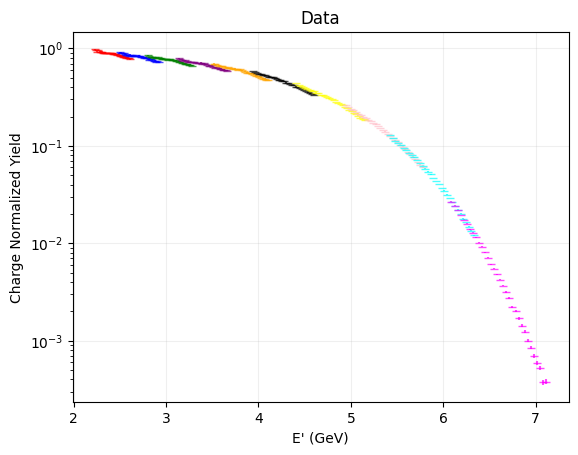

In [205]:
print("Type for delta_bin_contents_2p42", type(delta_bin_contents_2p42[0]))
print("Type for prod_scale_2p42", type(prod_scale_2p42))
print("Type for csb_contents_2p42", type(csb_contents_2p42[0]))
print("Type for subtracted_bin_contents_2p42", type(subtracted_bin_contents_2p42[0]))

# Perform the subtraction only at non-zero indices. Multiply the csb contents by the prod_scale to match the scaling of eprime_bin_contents
subtracted_bin_contents_2p42 -= csb_contents_2p42 * prod_scale_2p42
subtracted_bin_contents_2p71 -= csb_contents_2p71 * prod_scale_2p71
subtracted_bin_contents_3p04 -= csb_contents_3p04 * prod_scale_3p04
subtracted_bin_contents_3p4 -= csb_contents_3p4 * prod_scale_3p4
subtracted_bin_contents_3p81 -= csb_contents_3p81 * prod_scale_3p81
subtracted_bin_contents_4p27 -= csb_contents_4p27 * prod_scale_4p27
subtracted_bin_contents_4p78 -= csb_contents_4p78 * prod_scale_4p78
subtracted_bin_contents_5p36 -= csb_contents_5p36 * prod_scale_5p36
subtracted_bin_contents_5p878 -= csb_contents_5p878 * prod_scale_5p878
subtracted_bin_contents_6p6 -= csb_contents_6p6 * prod_scale_6p6

# Add the errors in quadrature
subtracted_bin_errors_2p42 = np.sqrt(subtracted_bin_errors_2p42**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
subtracted_bin_errors_2p71 = np.sqrt(subtracted_bin_errors_2p71**2 + (csb_contents_2p71 * prod_scale_2p71)**2)
subtracted_bin_errors_3p04 = np.sqrt(subtracted_bin_errors_3p04**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
subtracted_bin_errors_3p4 = np.sqrt(subtracted_bin_errors_3p4**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
subtracted_bin_errors_3p81 = np.sqrt(subtracted_bin_errors_3p81**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
subtracted_bin_errors_4p27 = np.sqrt(subtracted_bin_errors_4p27**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
subtracted_bin_errors_4p78 = np.sqrt(subtracted_bin_errors_4p78**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
subtracted_bin_errors_5p36 = np.sqrt(subtracted_bin_errors_5p36**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
subtracted_bin_errors_5p878 = np.sqrt(subtracted_bin_errors_5p878**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
subtracted_bin_errors_6p6 = np.sqrt(subtracted_bin_errors_6p6**2 + (csb_contents_6p6 * prod_scale_6p6)**2)

#fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
ax.errorbar(binned_eprime_bin_centers_2p42, delta_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')
ax.errorbar(binned_eprime_bin_centers_2p71, delta_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax.errorbar(binned_eprime_bin_centers_3p04, delta_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax.errorbar(binned_eprime_bin_centers_3p4, delta_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'purple', alpha = 0.7, label = '3.4 GeV')
ax.errorbar(binned_eprime_bin_centers_3p81, delta_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'orange', alpha = 0.7, label = '3.81 GeV')
ax.errorbar(binned_eprime_bin_centers_4p27, delta_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'black', alpha = 0.7, label = '4.27 GeV')
ax.errorbar(binned_eprime_bin_centers_4p78, delta_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.78 GeV')
ax.errorbar(binned_eprime_bin_centers_5p36, delta_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'pink', alpha = 0.7, label = '5.36 GeV')
ax.errorbar(binned_eprime_bin_centers_5p878, delta_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax.errorbar(binned_eprime_bin_centers_6p6, delta_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'magenta', alpha = 0.7, label = '6.6 GeV')
ax.set_ylabel('Charge Normalized Yield')
ax.set_xlabel('E\' (GeV)')
ax.set_title('Data')
ax.set_yscale('log')
ax.grid(alpha = 0.2)
# fig.savefig(f'{folder}/{nsimstring}_{dsimstring}_newyield.pdf')

<h1 align="center">SIMULATION WORK FOR NTG</h1>


Should be -8 and +8 -8.081665 7.8944216


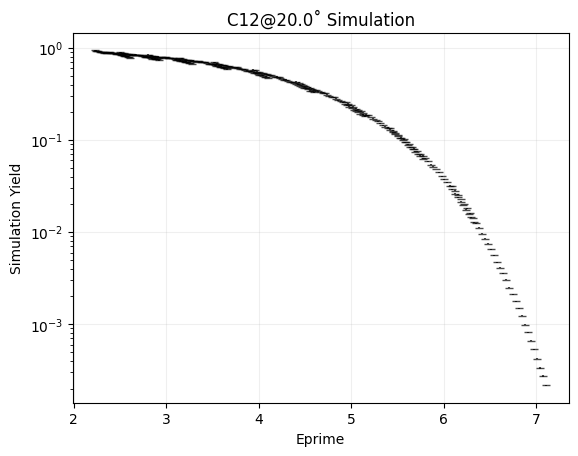

In [206]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_{nsimstring}22_hms.out")

Eprime_dict = {}
delta_dict = {}
xsec_array = {}
mc_scale = {}
thetadict = {}
idang = int(dang)

for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{nsimstring}_{idang}degm{string}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) <= 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)

    # New delta correction
    # Perform the delta correction
    electrons["hsdelta"] = (0.990337 * electrons["hsdelta"]) - 0.00236077 * (electrons["hsdelta"]**2) + 0.000286814 * (electrons["hsdelta"]**3) + 2.09878E-6 * (electrons["hsdelta"]**4) - 2.48674E-6 * (electrons["hsdelta"]**5) + 1.8646E-7 * (electrons["hsdelta"]**6)

    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut

    # Calculate E' and theta (in degrees)
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation
    thetadict[momentum] = thetadeg

hsdelta_min = np.min(delta_dict[2.42])
hsdelta_max = np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_num_bins = 32
# hsdelta_binwidth = (hsdelta_max - hsdelta_min) / hsdelta_num_bins
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, hsdelta_num_bins + 1)

#This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_edges_delta_2p42 = np.histogram(delta_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hsdelta_binedges)[1]
bin_edges_delta_2p71 = np.histogram(delta_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hsdelta_binedges)[1]
bin_edges_delta_3p04 = np.histogram(delta_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hsdelta_binedges)[1]
bin_edges_delta_3p4 = np.histogram(delta_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hsdelta_binedges)[1]
bin_edges_delta_3p81 = np.histogram(delta_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hsdelta_binedges)[1]
bin_edges_delta_4p27 = np.histogram(delta_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hsdelta_binedges)[1]
bin_edges_delta_4p78 = np.histogram(delta_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hsdelta_binedges)[1]
bin_edges_delta_5p36 = np.histogram(delta_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hsdelta_binedges)[1]
bin_edges_delta_5p878 = np.histogram(delta_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hsdelta_binedges)[1]
bin_edges_delta_6p6 = np.histogram(delta_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hsdelta_binedges)[1]

bin_counts_eprime_2p42_mc, bin_errors_eprime_2p42_mc = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42], hsdelta_binedges)
bin_counts_eprime_2p71_mc, bin_errors_eprime_2p71_mc = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71], hsdelta_binedges)
bin_counts_eprime_3p04_mc, bin_errors_eprime_3p04_mc = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04], hsdelta_binedges)
bin_counts_eprime_3p4_mc, bin_errors_eprime_3p4_mc = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4], hsdelta_binedges)
bin_counts_eprime_3p81_mc, bin_errors_eprime_3p81_mc = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81], hsdelta_binedges)
bin_counts_eprime_4p27_mc, bin_errors_eprime_4p27_mc = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27], hsdelta_binedges)
bin_counts_eprime_4p78_mc, bin_errors_eprime_4p78_mc = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78], hsdelta_binedges)
bin_counts_eprime_5p36_mc, bin_errors_eprime_5p36_mc = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36], hsdelta_binedges)
bin_counts_eprime_5p878_mc, bin_errors_eprime_5p878_mc = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878], hsdelta_binedges)
bin_counts_eprime_6p6_mc, bin_errors_eprime_6p6_mc = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6], hsdelta_binedges)

bin_centers_delta_2p42 = (bin_edges_delta_2p42[:-1] + bin_edges_delta_2p42[1:]) / 2
bin_centers_delta_2p71 = (bin_edges_delta_2p71[:-1] + bin_edges_delta_2p71[1:]) / 2
bin_centers_delta_3p04 = (bin_edges_delta_3p04[:-1] + bin_edges_delta_3p04[1:]) / 2
bin_centers_delta_3p4 = (bin_edges_delta_3p4[:-1] + bin_edges_delta_3p4[1:]) / 2
bin_centers_delta_3p81 = (bin_edges_delta_3p81[:-1] + bin_edges_delta_3p81[1:]) / 2
bin_centers_delta_4p27 = (bin_edges_delta_4p27[:-1] + bin_edges_delta_4p27[1:]) / 2
bin_centers_delta_4p78 = (bin_edges_delta_4p78[:-1] + bin_edges_delta_4p78[1:]) / 2
bin_centers_delta_5p36 = (bin_edges_delta_5p36[:-1] + bin_edges_delta_5p36[1:]) / 2
bin_centers_delta_5p878 = (bin_edges_delta_5p878[:-1] + bin_edges_delta_5p878[1:]) / 2
bin_centers_delta_6p6 = (bin_edges_delta_6p6[:-1] + bin_edges_delta_6p6[1:]) / 2

binned_eprime_bin_centers_2p42_mc = 2.42 * (1 + 0.01 * bin_centers_delta_2p42)
binned_eprime_bin_centers_2p71_mc = 2.71 * (1 + 0.01 * bin_centers_delta_2p71)
binned_eprime_bin_centers_3p04_mc = 3.04 * (1 + 0.01 * bin_centers_delta_3p04)
binned_eprime_bin_centers_3p4_mc = 3.4 * (1 + 0.01 * bin_centers_delta_3p4)
binned_eprime_bin_centers_3p81_mc = 3.81 * (1 + 0.01 * bin_centers_delta_3p81)
binned_eprime_bin_centers_4p27_mc = 4.27 * (1 + 0.01 * bin_centers_delta_4p27)
binned_eprime_bin_centers_4p78_mc = 4.78 * (1 + 0.01 * bin_centers_delta_4p78)
binned_eprime_bin_centers_5p36_mc = 5.36 * (1 + 0.01 * bin_centers_delta_5p36)
binned_eprime_bin_centers_5p878_mc = 5.878 * (1 + 0.01 * bin_centers_delta_5p878)
binned_eprime_bin_centers_6p6_mc = 6.6 * (1 + 0.01 * bin_centers_delta_6p6)

#Plotting the histogram with error bars
fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42_mc, bin_counts_eprime_2p42_mc, yerr = bin_errors_eprime_2p42_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71_mc, bin_counts_eprime_2p71_mc, yerr = bin_errors_eprime_2p71_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04_mc, bin_counts_eprime_3p04_mc, yerr = bin_errors_eprime_3p04_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4_mc, bin_counts_eprime_3p4_mc, fmt = '_', yerr = bin_errors_eprime_3p4_mc, color = 'black', alpha = 0.7, label = 'Sim 3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81_mc, bin_counts_eprime_3p81_mc, yerr = bin_errors_eprime_3p81_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27_mc, bin_counts_eprime_4p27_mc, yerr = bin_errors_eprime_4p27_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78_mc, bin_counts_eprime_4p78_mc, yerr = bin_errors_eprime_4p78_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36_mc, bin_counts_eprime_5p36_mc, yerr = bin_errors_eprime_5p36_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.36 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p878_mc, bin_counts_eprime_5p878_mc, yerr = bin_errors_eprime_5p878_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.878 GeV')
ax2.errorbar(binned_eprime_bin_centers_6p6_mc, bin_counts_eprime_6p6_mc, yerr = bin_errors_eprime_6p6_mc, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 6.6 GeV')
ax2.grid(alpha = 0.2)
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Simulation Yield')
ax2.set_yscale('log')
# ax.legend() 
ax2.set_title(f'{ntg}@{dang}˚ Simulation')
fig2.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

# Making theta acceptance plots

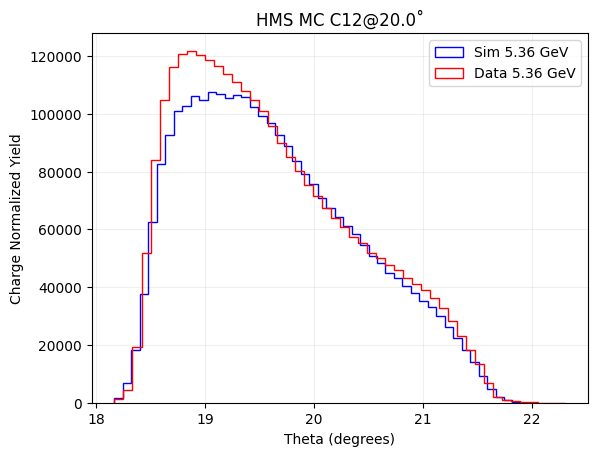

In [207]:
plt.hist(thetadict[5.36], bins = 50, weights = (xsec_array[5.36] * mc_scale[5.36]) / prod_scale_5p36, histtype = 'step', color = 'blue', label = 'Sim 5.36 GeV')
plt.hist(theta_dict[5.36], bins = 50, histtype = 'step', color = 'red', label = 'Data 5.36 GeV')
plt.xlabel('Theta (degrees)')
plt.ylabel('Charge Normalized Yield')
plt.title(f'HMS MC {ntg}@{dang}˚')
plt.grid(alpha = 0.2)
# plt.yscale('log')
plt.legend()
# plt.savefig(f'{folder}/theta_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


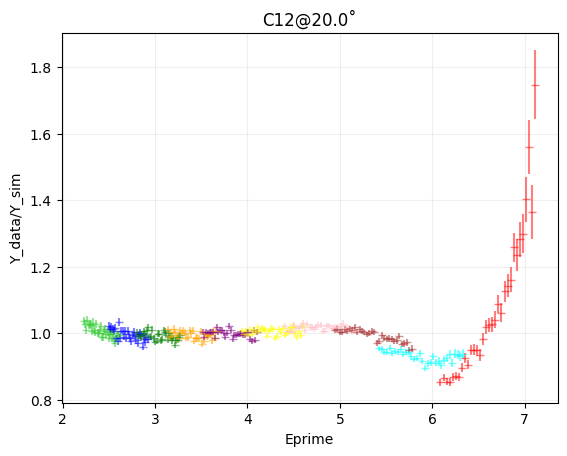

In [208]:
# print("Length of subtracted bin contents:", len(subtracted_bin_contents_2p42))
# print("Length of bin counts:", len(bin_counts_eprime_2p42_mc))

ratio_eprime_2p42_ntg = subtracted_bin_contents_2p42 / bin_counts_eprime_2p42_mc
ratio_eprime_2p71_ntg = subtracted_bin_contents_2p71 / bin_counts_eprime_2p71_mc
ratio_eprime_3p04_ntg = subtracted_bin_contents_3p04 / bin_counts_eprime_3p04_mc
ratio_eprime_3p4_ntg = subtracted_bin_contents_3p4 / bin_counts_eprime_3p4_mc
ratio_eprime_3p81_ntg = subtracted_bin_contents_3p81 / bin_counts_eprime_3p81_mc
ratio_eprime_4p27_ntg = subtracted_bin_contents_4p27 / bin_counts_eprime_4p27_mc
ratio_eprime_4p78_ntg = subtracted_bin_contents_4p78 / bin_counts_eprime_4p78_mc
ratio_eprime_5p36_ntg = subtracted_bin_contents_5p36 / bin_counts_eprime_5p36_mc
ratio_eprime_5p878_ntg = subtracted_bin_contents_5p878 / bin_counts_eprime_5p878_mc
ratio_eprime_6p6_ntg = subtracted_bin_contents_6p6 / bin_counts_eprime_6p6_mc

# print("Length of ratio:", len(ratio_eprime_2p42))
# print("Length of bin_centers:", len(subtracted_bin_contents_2p42))
# print("Length of bin_errors:", len(bin_errors_eprime_2p42_mc))
# print("Length of bin_counts:", len(bin_counts_eprime_2p42_mc))
# print("Length of bin_errors:", len(subtracted_bin_errors_2p42))

# Add errors in quadrature. First is data and second is MC
ratio_errors_2p42 = ratio_eprime_2p42_ntg * np.sqrt((subtracted_bin_errors_2p42 / subtracted_bin_contents_2p42)**2 + (bin_errors_eprime_2p42_mc / bin_counts_eprime_2p42_mc)**2)
ratio_errors_2p71 = ratio_eprime_2p71_ntg * np.sqrt((subtracted_bin_errors_2p71 / subtracted_bin_contents_2p71)**2 + (bin_errors_eprime_2p71_mc / bin_counts_eprime_2p71_mc)**2)
ratio_errors_3p04 = ratio_eprime_3p04_ntg * np.sqrt((subtracted_bin_errors_3p04 / subtracted_bin_contents_3p04)**2 + (bin_errors_eprime_3p04_mc / bin_counts_eprime_3p04_mc)**2)
ratio_errors_3p4 = ratio_eprime_3p4_ntg * np.sqrt((subtracted_bin_errors_3p4 / subtracted_bin_contents_3p4)**2 + (bin_errors_eprime_3p4_mc / bin_counts_eprime_3p4_mc)**2)
ratio_errors_3p81 = ratio_eprime_3p81_ntg * np.sqrt((subtracted_bin_errors_3p81 / subtracted_bin_contents_3p81)**2 + (bin_errors_eprime_3p81_mc / bin_counts_eprime_3p81_mc)**2)
ratio_errors_4p27 = ratio_eprime_4p27_ntg * np.sqrt((subtracted_bin_errors_4p27 / subtracted_bin_contents_4p27)**2 + (bin_errors_eprime_4p27_mc / bin_counts_eprime_4p27_mc)**2)
ratio_errors_4p78 = ratio_eprime_4p78_ntg * np.sqrt((subtracted_bin_errors_4p78 / subtracted_bin_contents_4p78)**2 + (bin_errors_eprime_4p78_mc / bin_counts_eprime_4p78_mc)**2)
ratio_errors_5p36 = ratio_eprime_5p36_ntg * np.sqrt((subtracted_bin_errors_5p36 / subtracted_bin_contents_5p36)**2 + (bin_errors_eprime_5p36_mc / bin_counts_eprime_5p36_mc)**2)
ratio_errors_5p878 = ratio_eprime_5p878_ntg * np.sqrt((subtracted_bin_errors_5p878 / subtracted_bin_contents_5p878)**2 + (bin_errors_eprime_5p878_mc / bin_counts_eprime_5p878_mc)**2)
ratio_errors_6p6 = ratio_eprime_6p6_ntg * np.sqrt((subtracted_bin_errors_6p6 / subtracted_bin_contents_6p6)**2 + (bin_errors_eprime_6p6_mc / bin_counts_eprime_6p6_mc)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_ntg, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.5, color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_ntg, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.5, color = 'blue', label = '2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_ntg, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.5, color = 'green', label = '3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_ntg, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.5, color = 'orange', label = '3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_ntg, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.5, color = 'purple', label = '3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_ntg, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.5, color = 'yellow', label = '4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_ntg, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.5, color = 'pink', label = '4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_ntg, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.5, color = 'brown', label = '5.36 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_ntg, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.5, color = 'cyan', label = '5.878 GeV')
ax2.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_ntg, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.5, color = 'red', label = '6.6 GeV')
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Y_data/Y_sim')
ax2.set_title(f'{ntg}@{dang}˚')
ax2.grid(True, alpha = 0.2)
# ax2.set_ylim(0.9,1.1)
fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{start_time:.0f}.pdf')

In [209]:
print(ratio_eprime_4p27_ntg)

[1.00898863 0.99811207 1.0067379  0.99637633 1.01286327 0.99806207
 1.01047914 1.00564543 1.01995802 1.00771542 1.01715723 1.01410584
 1.01017864 0.99331363 1.00573984 1.01482436 1.01351225 0.98556511
 0.99185997 1.01237679 1.00522565 1.01471834 0.99471278 1.00197269
 1.00981474 1.01813353 1.02058536 0.99966945 0.99051066 1.00795188
 0.99484066 1.02188499]


<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


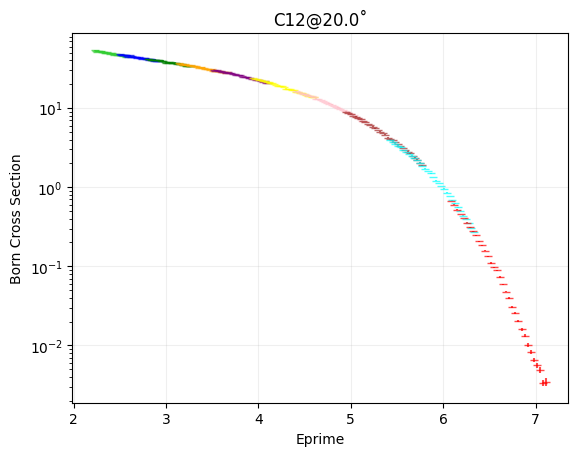

In [210]:
# Get points to interpolate based on angle and E'
points_to_interpolate_2p42 = np.column_stack((binned_eprime_bin_centers_2p42, np.full(len(binned_eprime_bin_centers_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((binned_eprime_bin_centers_2p71, np.full(len(binned_eprime_bin_centers_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((binned_eprime_bin_centers_3p04, np.full(len(binned_eprime_bin_centers_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((binned_eprime_bin_centers_3p4, np.full(len(binned_eprime_bin_centers_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((binned_eprime_bin_centers_3p81, np.full(len(binned_eprime_bin_centers_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((binned_eprime_bin_centers_4p27, np.full(len(binned_eprime_bin_centers_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((binned_eprime_bin_centers_4p78, np.full(len(binned_eprime_bin_centers_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((binned_eprime_bin_centers_5p36, np.full(len(binned_eprime_bin_centers_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((binned_eprime_bin_centers_5p878, np.full(len(binned_eprime_bin_centers_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((binned_eprime_bin_centers_6p6, np.full(len(binned_eprime_bin_centers_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42_ntg = griddata(points, V6, points_to_interpolate_2p42, method = 'linear') # points is just the whole stack of 2D array of [E', theta] from the table
born_xsec_array_2p71_ntg = griddata(points, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_ntg = griddata(points, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_ntg = griddata(points, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_ntg = griddata(points, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_ntg = griddata(points, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_ntg = griddata(points, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_ntg = griddata(points, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_ntg = griddata(points, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_ntg = griddata(points, V6, points_to_interpolate_6p6, method = 'linear')
# print("Length of born_xsec_array", len(born_xsec_array))

# Get the QE piece
qe_array_2p42_ntg = griddata(points, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_ntg = griddata(points, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_ntg = griddata(points, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_ntg = griddata(points, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_ntg = griddata(points, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_ntg = griddata(points, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_ntg = griddata(points, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_ntg = griddata(points, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_ntg = griddata(points, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_ntg = griddata(points, V8, points_to_interpolate_6p6, method = 'linear')

# Get the inelastic piece
inelastic_array_2p42_ntg = griddata(points, V7, points_to_interpolate_2p42, method = 'linear')
inelastic_array_2p71_ntg = griddata(points, V7, points_to_interpolate_2p71, method = 'linear')
inelastic_array_3p04_ntg = griddata(points, V7, points_to_interpolate_3p04, method = 'linear')
inelastic_array_3p4_ntg = griddata(points, V7, points_to_interpolate_3p4, method = 'linear')
inelastic_array_3p81_ntg = griddata(points, V7, points_to_interpolate_3p81, method = 'linear')
inelastic_array_4p27_ntg = griddata(points, V7, points_to_interpolate_4p27, method = 'linear')
inelastic_array_4p78_ntg = griddata(points, V7, points_to_interpolate_4p78, method = 'linear')
inelastic_array_5p36_ntg = griddata(points, V7, points_to_interpolate_5p36, method = 'linear')
inelastic_array_5p878_ntg = griddata(points, V7, points_to_interpolate_5p878, method = 'linear')
inelastic_array_6p6_ntg = griddata(points, V7, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42 = griddata(points, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71 = griddata(points, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04 = griddata(points, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4 = griddata(points, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81 = griddata(points, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27 = griddata(points, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78 = griddata(points, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36 = griddata(points, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878 = griddata(points, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6 = griddata(points, V13, points_to_interpolate_6p6, method = 'linear')

fig3, ax3 = plt.subplots()
# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_ntg = ratio_eprime_2p42_ntg * born_xsec_array_2p42_ntg * ccf_2p42
born_cross_2p71_ntg = ratio_eprime_2p71_ntg * born_xsec_array_2p71_ntg * ccf_2p71
born_cross_3p04_ntg = ratio_eprime_3p04_ntg * born_xsec_array_3p04_ntg * ccf_3p04
born_cross_3p4_ntg= ratio_eprime_3p4_ntg * born_xsec_array_3p4_ntg * ccf_3p4
born_cross_3p81_ntg = ratio_eprime_3p81_ntg * born_xsec_array_3p81_ntg * ccf_3p81
born_cross_4p27_ntg = ratio_eprime_4p27_ntg * born_xsec_array_4p27_ntg * ccf_4p27
born_cross_4p78_ntg = ratio_eprime_4p78_ntg * born_xsec_array_4p78_ntg * ccf_4p78
born_cross_5p36_ntg = ratio_eprime_5p36_ntg * born_xsec_array_5p36_ntg * ccf_5p36
born_cross_5p878_ntg = ratio_eprime_5p878_ntg * born_xsec_array_5p878_ntg * ccf_5p878
born_cross_6p6_ntg= ratio_eprime_6p6_ntg * born_xsec_array_6p6_ntg * ccf_6p6

fac_2p42_ntg = ratio_eprime_2p42_ntg * ccf_2p42
fac_2p71_ntg = ratio_eprime_2p71_ntg * ccf_2p71
fac_3p04_ntg = ratio_eprime_3p04_ntg * ccf_3p04
fac_3p4_ntg = ratio_eprime_3p4_ntg * ccf_3p4
fac_3p81_ntg = ratio_eprime_3p81_ntg * ccf_3p81
fac_4p27_ntg = ratio_eprime_4p27_ntg * ccf_4p27
fac_4p78_ntg = ratio_eprime_4p78_ntg * ccf_4p78
fac_5p36_ntg = ratio_eprime_5p36_ntg * ccf_5p36
fac_5p878_ntg = ratio_eprime_5p878_ntg * ccf_5p878
fac_6p6_ntg = ratio_eprime_6p6_ntg * ccf_6p6

# print("Length of born_cross", len(born_cross))
# print("Born cross section", born_cross)
born_errors_2p42_ntg = born_cross_2p42_ntg * ratio_errors_2p42
born_errors_2p71_ntg = born_cross_2p71_ntg * ratio_errors_2p71
born_errors_3p04_ntg = born_cross_3p04_ntg * ratio_errors_3p04
born_errors_3p4_ntg = born_cross_3p4_ntg * ratio_errors_3p4
born_errors_3p81_ntg = born_cross_3p81_ntg * ratio_errors_3p81
born_errors_4p27_ntg = born_cross_4p27_ntg * ratio_errors_4p27
born_errors_4p78_ntg = born_cross_4p78_ntg * ratio_errors_4p78
born_errors_5p36_ntg = born_cross_5p36_ntg * ratio_errors_5p36
born_errors_5p878_ntg = born_cross_5p878_ntg * ratio_errors_5p878
born_errors_6p6_ntg = born_cross_6p6_ntg * ratio_errors_6p6

ax3.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_ntg, yerr = born_errors_2p42_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_ntg, yerr = born_errors_2p71_ntg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_ntg, yerr = born_errors_3p04_ntg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_ntg, yerr = born_errors_3p4_ntg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_ntg, yerr = born_errors_3p81_ntg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_ntg, yerr = born_errors_4p27_ntg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_ntg, yerr = born_errors_4p78_ntg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_ntg, yerr = born_errors_5p36_ntg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_ntg, yerr = born_errors_5p878_ntg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax3.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_ntg, yerr = born_errors_6p6_ntg, fmt = '_', alpha = 0.7, color = 'red', label = '6.6 GeV')
ax3.set_xlabel('Eprime')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{dang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(alpha = 0.2)
fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


In [211]:
Z, A = 13, 27 # Target
E = 0.19535 # Ratio of dummy to target cell thickness

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in Dummy_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts)/np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

dummy_eprime_bin_contents_2p42, dummy_eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, hsdelta_binedges, ald)
dummy_eprime_bin_contents_2p71, dummy_eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p04, dummy_eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p4, dummy_eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p81, dummy_eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, hsdelta_binedges, ald)
dummy_eprime_bin_contents_4p27, dummy_eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, hsdelta_binedges, ald)
dummy_eprime_bin_contents_4p78, dummy_eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, hsdelta_binedges, ald)
dummy_eprime_bin_contents_5p36, dummy_eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, hsdelta_binedges, ald)
dummy_eprime_bin_contents_5p878, dummy_eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, hsdelta_binedges, ald)
dummy_eprime_bin_contents_6p6, dummy_eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, hsdelta_binedges, ald)

<h1 align="center">DATA WORK FOR DTG</h1>

Text(0.5, 1.0, 'Dummy Subtracted LD2 Data Yield')

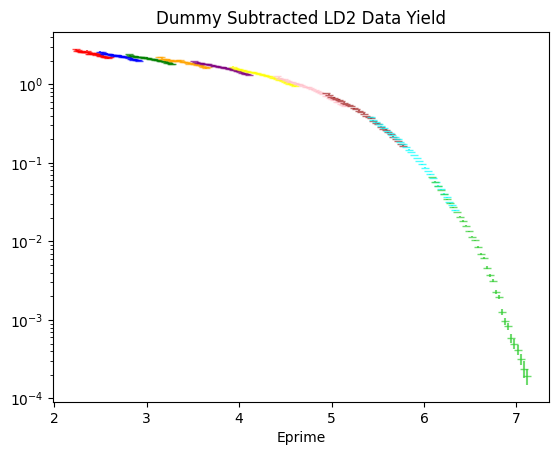

In [212]:
# Kinematic variables
Z, A = target_info[dtg][0], target_info[dtg][1]  #Target
thick = target_info[dtg][2] # g/cm2. From Cameron's target sheet column 'R'
thick = thick * 0.996 # Cryo target contraction correction factor
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
ytar = {}
ytar_hist = {}
for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in LD2_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    delta_hist[momentum] = np.array(dp_cut)

eprime_bin_contents_2p42, eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, dtg)
eprime_bin_contents_2p71, eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, dtg)
eprime_bin_contents_3p04, eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, dtg)
eprime_bin_contents_3p4, eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, dtg)
eprime_bin_contents_3p81, eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, dtg)
eprime_bin_contents_4p27, eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, dtg)
eprime_bin_contents_4p78, eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, dtg)
eprime_bin_contents_5p36, eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, dtg)
eprime_bin_contents_5p878, eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, dtg)
eprime_bin_contents_6p6, eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, dtg)

fig4, ax4 = plt.subplots()

# Perform Dummy Subtraction
eprime_bin_contents_2p42 = eprime_bin_contents_2p42 - E * dummy_eprime_bin_contents_2p42
eprime_bin_contents_2p71 = eprime_bin_contents_2p71 - E * dummy_eprime_bin_contents_2p71
eprime_bin_contents_3p04 = eprime_bin_contents_3p04 - E * dummy_eprime_bin_contents_3p04
eprime_bin_contents_3p4 = eprime_bin_contents_3p4 - E * dummy_eprime_bin_contents_3p4
eprime_bin_contents_3p81 = eprime_bin_contents_3p81 - E * dummy_eprime_bin_contents_3p81
eprime_bin_contents_4p27 = eprime_bin_contents_4p27 - E * dummy_eprime_bin_contents_4p27
eprime_bin_contents_4p78 = eprime_bin_contents_4p78 - E * dummy_eprime_bin_contents_4p78
eprime_bin_contents_5p36 = eprime_bin_contents_5p36 - E * dummy_eprime_bin_contents_5p36
eprime_bin_contents_5p878 = eprime_bin_contents_5p878 - E * dummy_eprime_bin_contents_5p878
eprime_bin_contents_6p6 = eprime_bin_contents_6p6 - E * dummy_eprime_bin_contents_6p6

#Error Prpoagation
eprime_bin_errors_2p42 = np.sqrt((eprime_bin_errors_2p42)**2 + (dummy_eprime_bin_errors_2p42)**2)
eprime_bin_errors_2p71 = np.sqrt((eprime_bin_errors_2p71)**2 + (dummy_eprime_bin_errors_2p71)**2)
eprime_bin_errors_3p04 = np.sqrt((eprime_bin_errors_3p04)**2 + (dummy_eprime_bin_errors_3p04)**2)
eprime_bin_errors_3p4 = np.sqrt((eprime_bin_errors_3p4)**2 + (dummy_eprime_bin_errors_3p4)**2)
eprime_bin_errors_3p81 = np.sqrt((eprime_bin_errors_3p81)**2 + (dummy_eprime_bin_errors_3p81)**2)
eprime_bin_errors_4p27 = np.sqrt((eprime_bin_errors_4p27)**2 + (dummy_eprime_bin_errors_4p27)**2)
eprime_bin_errors_4p78 = np.sqrt((eprime_bin_errors_4p78)**2 + (dummy_eprime_bin_errors_4p78)**2)
eprime_bin_errors_5p36 = np.sqrt((eprime_bin_errors_5p36)**2 + (dummy_eprime_bin_errors_5p36)**2)
eprime_bin_errors_5p878 = np.sqrt((eprime_bin_errors_5p878)**2 + (dummy_eprime_bin_errors_5p878)**2)
eprime_bin_errors_6p6 = np.sqrt((eprime_bin_errors_6p6)**2 + (dummy_eprime_bin_errors_6p6)**2)

prod_scale_2p42 = read_report(2.42, dtg)
prod_scale_2p71 = read_report(2.71, dtg)
prod_scale_3p04 = read_report(3.04, dtg)
prod_scale_3p4 = read_report(3.4, dtg)
prod_scale_3p81 = read_report(3.81, dtg)
prod_scale_4p27 = read_report(4.27, dtg)
prod_scale_4p78 = read_report(4.78, dtg)
prod_scale_5p36 = read_report(5.36, dtg)
prod_scale_5p878 = read_report(5.878, dtg)
prod_scale_6p6 = read_report(6.6, dtg)

#Perform charge symmetric background subtraction
csb_contents_2p42 = csb(binned_eprime_bin_centers_2p42[eprime_bin_contents_2p42 != 0], dtg, dang)
csb_contents_2p71 = csb(binned_eprime_bin_centers_2p71[eprime_bin_contents_2p71 != 0], dtg, dang)
csb_contents_3p04 = csb(binned_eprime_bin_centers_3p04[eprime_bin_contents_3p04 != 0], dtg, dang)
csb_contents_3p4 = csb(binned_eprime_bin_centers_3p4[eprime_bin_contents_3p4 != 0], dtg, dang)
csb_contents_3p81 = csb(binned_eprime_bin_centers_3p81[eprime_bin_contents_3p81 != 0], dtg, dang)
csb_contents_4p27 = csb(binned_eprime_bin_centers_4p27[eprime_bin_contents_4p27 != 0], dtg, dang)
csb_contents_4p78 = csb(binned_eprime_bin_centers_4p78[eprime_bin_contents_4p78 != 0], dtg, dang)
csb_contents_5p36 = csb(binned_eprime_bin_centers_5p36[eprime_bin_contents_5p36 != 0], dtg, dang)
csb_contents_5p878 = csb(binned_eprime_bin_centers_5p878[eprime_bin_contents_5p878 != 0], dtg, dang)
csb_contents_6p6 = csb(binned_eprime_bin_centers_6p6[eprime_bin_contents_6p6 != 0], dtg, dang)

# print("non zero indices of eprime_bin_contents_2p71", np.nonzero(eprime_bin_contents_2p71)[0])

# Initialize the resulting array with the original contents
subtracted_bin_contents_2p42 = np.array(eprime_bin_contents_2p42)
subtracted_bin_contents_2p71 = np.array(eprime_bin_contents_2p71)
subtracted_bin_contents_3p04 = np.array(eprime_bin_contents_3p04)
subtracted_bin_contents_3p4 = np.array(eprime_bin_contents_3p4)
subtracted_bin_contents_3p81 = np.array(eprime_bin_contents_3p81)
subtracted_bin_contents_4p27 = np.array(eprime_bin_contents_4p27)
subtracted_bin_contents_4p78 = np.array(eprime_bin_contents_4p78)
subtracted_bin_contents_5p36 = np.array(eprime_bin_contents_5p36)
subtracted_bin_contents_5p878 = np.array(eprime_bin_contents_5p878)
subtracted_bin_contents_6p6 = np.array(eprime_bin_contents_6p6)

# Find non-zero indices
non_zero_indices_2p42 = np.nonzero(eprime_bin_contents_2p42)[0]
non_zero_indices_2p71 = np.nonzero(eprime_bin_contents_2p71)[0]
non_zero_indices_3p04 = np.nonzero(eprime_bin_contents_3p04)[0]
non_zero_indices_3p4 = np.nonzero(eprime_bin_contents_3p4)[0]
non_zero_indices_3p81 = np.nonzero(eprime_bin_contents_3p81)[0]
non_zero_indices_4p27 = np.nonzero(eprime_bin_contents_4p27)[0]
non_zero_indices_4p78 = np.nonzero(eprime_bin_contents_4p78)[0]
non_zero_indices_5p36 = np.nonzero(eprime_bin_contents_5p36)[0]
non_zero_indices_5p878 = np.nonzero(eprime_bin_contents_5p878)[0]
non_zero_indices_6p6 = np.nonzero(eprime_bin_contents_6p6)[0]

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
# Perform the subtraction only at non-zero indices
    subtracted_bin_contents_2p42[non_zero_indices_2p42] -= csb_contents_2p42 * prod_scale_2p42
    subtracted_bin_contents_2p71[non_zero_indices_2p71] -= csb_contents_2p71 * prod_scale_2p71
    subtracted_bin_contents_3p04[non_zero_indices_3p04] -= csb_contents_3p04 * prod_scale_3p04
    subtracted_bin_contents_3p4[non_zero_indices_3p4] -= csb_contents_3p4 * prod_scale_3p4
    subtracted_bin_contents_3p81[non_zero_indices_3p81] -= csb_contents_3p81 * prod_scale_3p81
    subtracted_bin_contents_4p27[non_zero_indices_4p27] -= csb_contents_4p27 * prod_scale_4p27
    subtracted_bin_contents_4p78[non_zero_indices_4p78] -= csb_contents_4p78 * prod_scale_4p78
    subtracted_bin_contents_5p36[non_zero_indices_5p36] -= csb_contents_5p36 * prod_scale_5p36
    subtracted_bin_contents_5p878[non_zero_indices_5p878] -= csb_contents_5p878 * prod_scale_5p878
    subtracted_bin_contents_6p6[non_zero_indices_6p6] -= csb_contents_6p6 * prod_scale_6p6
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

subtracted_bin_errors_2p42 = np.array(eprime_bin_errors_2p42)
subtracted_bin_errors_2p71 = np.array(eprime_bin_errors_2p71)
subtracted_bin_errors_3p04 = np.array(eprime_bin_errors_3p04)
subtracted_bin_errors_3p4 = np.array(eprime_bin_errors_3p4)
subtracted_bin_errors_3p81 = np.array(eprime_bin_errors_3p81)
subtracted_bin_errors_4p27 = np.array(eprime_bin_errors_4p27)
subtracted_bin_errors_4p78 = np.array(eprime_bin_errors_4p78)
subtracted_bin_errors_5p36 = np.array(eprime_bin_errors_5p36)
subtracted_bin_errors_5p878 = np.array(eprime_bin_errors_5p878)
subtracted_bin_errors_6p6 = np.array(eprime_bin_errors_6p6)

if len(non_zero_indices_2p71) == len(csb_contents_2p71):
    subtracted_bin_errors_2p42[non_zero_indices_2p42] = np.sqrt(subtracted_bin_errors_2p42[non_zero_indices_2p42]**2 + (csb_contents_2p42 * prod_scale_2p42)**2)
    subtracted_bin_errors_2p71[non_zero_indices_2p71] = np.sqrt(subtracted_bin_errors_2p71[non_zero_indices_2p71]**2 + (csb_contents_2p71 * prod_scale_2p71)**2)
    subtracted_bin_errors_3p04[non_zero_indices_3p04] = np.sqrt(subtracted_bin_errors_3p04[non_zero_indices_3p04]**2 + (csb_contents_3p04 * prod_scale_3p04)**2)
    subtracted_bin_errors_3p4[non_zero_indices_3p4] = np.sqrt(subtracted_bin_errors_3p4[non_zero_indices_3p4]**2 + (csb_contents_3p4 * prod_scale_3p4)**2)
    subtracted_bin_errors_3p81[non_zero_indices_3p81] = np.sqrt(subtracted_bin_errors_3p81[non_zero_indices_3p81]**2 + (csb_contents_3p81 * prod_scale_3p81)**2)
    subtracted_bin_errors_4p27[non_zero_indices_4p27] = np.sqrt(subtracted_bin_errors_4p27[non_zero_indices_4p27]**2 + (csb_contents_4p27 * prod_scale_4p27)**2)
    subtracted_bin_errors_4p78[non_zero_indices_4p78] = np.sqrt(subtracted_bin_errors_4p78[non_zero_indices_4p78]**2 + (csb_contents_4p78 * prod_scale_4p78)**2)
    subtracted_bin_errors_5p36[non_zero_indices_5p36] = np.sqrt(subtracted_bin_errors_5p36[non_zero_indices_5p36]**2 + (csb_contents_5p36 * prod_scale_5p36)**2)
    subtracted_bin_errors_5p878[non_zero_indices_5p878] = np.sqrt(subtracted_bin_errors_5p878[non_zero_indices_5p878]**2 + (csb_contents_5p878 * prod_scale_5p878)**2)
    subtracted_bin_errors_6p6[non_zero_indices_6p6] = np.sqrt(subtracted_bin_errors_6p6[non_zero_indices_6p6]**2 + (csb_contents_6p6 * prod_scale_6p6)**2)
else:
    raise ValueError("The number of non-zero elements in eprime_bin_contents_2p71 does not match the length of csb_contents_2p71.")

ax4.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
ax4.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax4.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
ax4.set_yscale('log')
ax4.set_xlabel('Eprime')
ax4.set_title('Dummy Subtracted LD2 Data Yield')

<h1 align="center">SIMULATION WORK FOR DTG</h1>


Should be -8 and +8 -8.081625 7.8944016


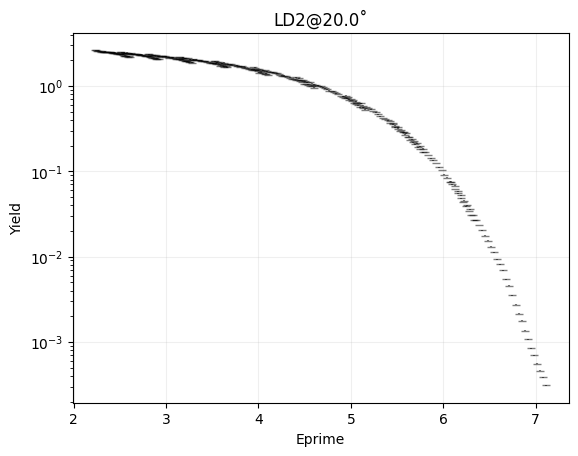

In [213]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_d2cryo22_hms.out")

ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
for momentum in dmom:
    string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{dsimstring}_20degm{string}.root"
    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdelta"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
            (np.abs(electrons["hsyptar"]) < 0.032) & \
            (np.abs(electrons["hsxptar"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    #Perform the delta correction
    electrons["hsdelta"] = (0.990337 * electrons["hsdelta"]) - 0.00236077 * (electrons["hsdelta"]**2) + 0.000286814 * (electrons["hsdelta"]**3) + 2.09878E-6 * (electrons["hsdelta"]**4) - 2.48674E-6 * (electrons["hsdelta"]**5) + 1.8646E-7 * (electrons["hsdelta"]**6)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), 1.5)

    # print("Length of ytar_weight", len(ytar_weight))
    # print("Length of Eprime_dict", len(Eprime_dict[momentum]))
    
    # Calculate theta (in degrees)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))  #Make a column stack of points to be interpolated for our given E' and theta
    xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method = 'linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation

hsdelta_min = np.min(delta_dict[2.42])
hsdelta_max = np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_num_bins = 32
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, hsdelta_num_bins + 1)

bin_counts_eprime_2p42, bin_errors_eprime_2p42 = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42] * jacobian_weight[2.42], hsdelta_binedges)
bin_counts_eprime_2p71, bin_errors_eprime_2p71 = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71] * jacobian_weight[2.71], hsdelta_binedges)
bin_counts_eprime_3p04, bin_errors_eprime_3p04 = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04] * jacobian_weight[3.04], hsdelta_binedges)
bin_counts_eprime_3p4, bin_errors_eprime_3p4 = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4] * jacobian_weight[3.4], hsdelta_binedges)
bin_counts_eprime_3p81, bin_errors_eprime_3p81 = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81] * jacobian_weight[3.81], hsdelta_binedges)
bin_counts_eprime_4p27, bin_errors_eprime_4p27 = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27] * jacobian_weight[4.27], hsdelta_binedges)
bin_counts_eprime_4p78, bin_errors_eprime_4p78 = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78] * jacobian_weight[4.78], hsdelta_binedges)
bin_counts_eprime_5p36, bin_errors_eprime_5p36 = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36] * jacobian_weight[5.36], hsdelta_binedges)
bin_counts_eprime_5p878, bin_errors_eprime_5p878 = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878] * jacobian_weight[5.878], hsdelta_binedges)
bin_counts_eprime_6p6, bin_errors_eprime_6p6 = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6] * jacobian_weight[6.6], hsdelta_binedges)

fig4, ax4 = plt.subplots()
# Plotting the histogram with error bars
ax4.errorbar(binned_eprime_bin_centers_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 2.42 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 2.71 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.04 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.4 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 3.81 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.27 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 4.78 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.36 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 5.878 GeV')
ax4.errorbar(binned_eprime_bin_centers_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 6.6 GeV')
ax4.grid(alpha = 0.2)
ax4.set_xlabel('Eprime')
ax4.set_ylabel('Yield')
ax4.set_yscale('log')
# ax4.legend() 
ax4.set_title(f'{dtg}@{dang}˚')
fig4.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

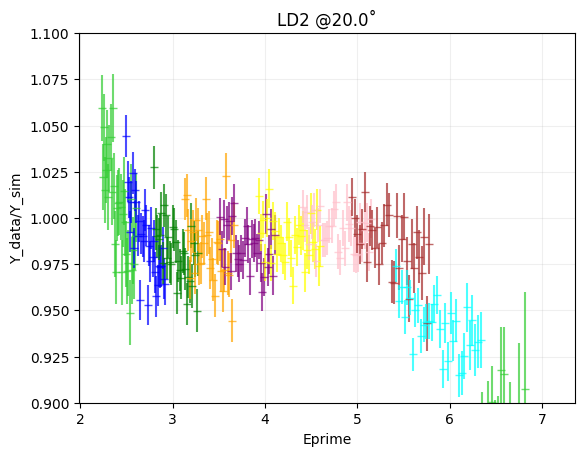

In [214]:
ratio_eprime_2p42_dtg = subtracted_bin_contents_2p42 / bin_counts_eprime_2p42
ratio_eprime_2p71_dtg = subtracted_bin_contents_2p71 / bin_counts_eprime_2p71
ratio_eprime_3p04_dtg = subtracted_bin_contents_3p04 / bin_counts_eprime_3p04
ratio_eprime_3p4_dtg = subtracted_bin_contents_3p4 / bin_counts_eprime_3p4
ratio_eprime_3p81_dtg = subtracted_bin_contents_3p81 / bin_counts_eprime_3p81
ratio_eprime_4p27_dtg = subtracted_bin_contents_4p27 / bin_counts_eprime_4p27
ratio_eprime_4p78_dtg = subtracted_bin_contents_4p78 / bin_counts_eprime_4p78
ratio_eprime_5p36_dtg = subtracted_bin_contents_5p36 / bin_counts_eprime_5p36
ratio_eprime_5p878_dtg = subtracted_bin_contents_5p878 / bin_counts_eprime_5p878
ratio_eprime_6p6_dtg = subtracted_bin_contents_6p6 / bin_counts_eprime_6p6

# Add errors in quadrature
ratio_errors_2p42 = ratio_eprime_2p42_dtg * np.sqrt((subtracted_bin_errors_2p42 / subtracted_bin_contents_2p42)**2 + (bin_errors_eprime_2p42 / bin_counts_eprime_2p42)**2)
ratio_errors_2p71 = ratio_eprime_2p71_dtg * np.sqrt((subtracted_bin_errors_2p71 / subtracted_bin_contents_2p71)**2 + (bin_errors_eprime_2p71 / bin_counts_eprime_2p71)**2)
ratio_errors_3p04 = ratio_eprime_3p04_dtg * np.sqrt((subtracted_bin_errors_3p04 / subtracted_bin_contents_3p04)**2 + (bin_errors_eprime_3p04 / bin_counts_eprime_3p04)**2)
ratio_errors_3p4 = ratio_eprime_3p4_dtg * np.sqrt((subtracted_bin_errors_3p4 / subtracted_bin_contents_3p4)**2 + (bin_errors_eprime_3p4 / bin_counts_eprime_3p4)**2)
ratio_errors_3p81 = ratio_eprime_3p81_dtg * np.sqrt((subtracted_bin_errors_3p81 / subtracted_bin_contents_3p81)**2 + (bin_errors_eprime_3p81 / bin_counts_eprime_3p81)**2)
ratio_errors_4p27 = ratio_eprime_4p27_dtg * np.sqrt((subtracted_bin_errors_4p27 / subtracted_bin_contents_4p27)**2 + (bin_errors_eprime_4p27 / bin_counts_eprime_4p27)**2)
ratio_errors_4p78 = ratio_eprime_4p78_dtg * np.sqrt((subtracted_bin_errors_4p78 / subtracted_bin_contents_4p78)**2 + (bin_errors_eprime_4p78 / bin_counts_eprime_4p78)**2)
ratio_errors_5p36 = ratio_eprime_5p36_dtg * np.sqrt((subtracted_bin_errors_5p36 / subtracted_bin_contents_5p36)**2 + (bin_errors_eprime_5p36 / bin_counts_eprime_5p36)**2)
ratio_errors_5p878 = ratio_eprime_5p878_dtg * np.sqrt((subtracted_bin_errors_5p878 / subtracted_bin_contents_5p878)**2 + (bin_errors_eprime_5p878 / bin_counts_eprime_5p878)**2)
ratio_errors_6p6 = ratio_eprime_6p6_dtg * np.sqrt((subtracted_bin_errors_6p6 / subtracted_bin_contents_6p6)**2 + (bin_errors_eprime_6p6 / bin_counts_eprime_6p6)**2)

fig5, ax5 = plt.subplots()
ax5.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_dtg, yerr = ratio_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax5.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_dtg, yerr = ratio_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_dtg, yerr = ratio_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_dtg, yerr = ratio_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_dtg, yerr = ratio_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_dtg, yerr = ratio_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_dtg, yerr = ratio_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax5.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_dtg, yerr = ratio_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax5.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_dtg, yerr = ratio_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax5.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_dtg, yerr = ratio_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax5.set_xlabel('Eprime')
ax5.set_ylabel('Y_data/Y_sim')
ax5.set_title(f'{dtg} @{dang}˚')
ax5.set_ylim(0.9, 1.1)
ax5.grid(alpha = 0.2)
fig5.savefig(f'{folder}/ratio_eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>

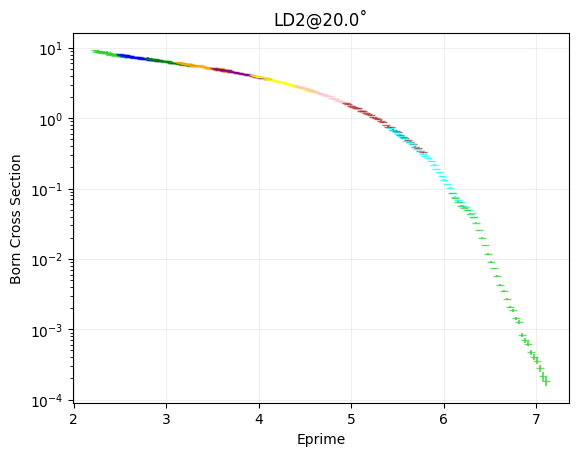

In [215]:
# Get points to interpolate based on angle and E'
points_to_interpolate_2p42 = np.column_stack((binned_eprime_bin_centers_2p42, np.full(len(binned_eprime_bin_centers_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((binned_eprime_bin_centers_2p71, np.full(len(binned_eprime_bin_centers_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((binned_eprime_bin_centers_3p04, np.full(len(binned_eprime_bin_centers_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((binned_eprime_bin_centers_3p4, np.full(len(binned_eprime_bin_centers_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((binned_eprime_bin_centers_3p81, np.full(len(binned_eprime_bin_centers_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((binned_eprime_bin_centers_4p27, np.full(len(binned_eprime_bin_centers_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((binned_eprime_bin_centers_4p78, np.full(len(binned_eprime_bin_centers_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((binned_eprime_bin_centers_5p36, np.full(len(binned_eprime_bin_centers_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((binned_eprime_bin_centers_5p878, np.full(len(binned_eprime_bin_centers_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((binned_eprime_bin_centers_6p6, np.full(len(binned_eprime_bin_centers_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42_dtg = griddata(points, V6, points_to_interpolate_2p42, method = 'linear')
born_xsec_array_2p71_dtg = griddata(points, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_dtg = griddata(points, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_dtg = griddata(points, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_dtg = griddata(points, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_dtg = griddata(points, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_dtg = griddata(points, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_dtg = griddata(points, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_dtg = griddata(points, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_dtg = griddata(points, V6, points_to_interpolate_6p6, method = 'linear')

# Get the QE piece
qe_array_2p42_dtg = griddata(points, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_dtg = griddata(points, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_dtg = griddata(points, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_dtg= griddata(points, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_dtg = griddata(points, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_dtg = griddata(points, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_dtg = griddata(points, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_dtg = griddata(points, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_dtg = griddata(points, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_dtg = griddata(points, V8, points_to_interpolate_6p6, method = 'linear')

# Get the inelastic piece
inelastic_array_2p42_dtg = griddata(points, V7, points_to_interpolate_2p42, method = 'linear')
inelastic_array_2p71_dtg = griddata(points, V7, points_to_interpolate_2p71, method = 'linear')
inelastic_array_3p04_dtg = griddata(points, V7, points_to_interpolate_3p04, method = 'linear')
inelastic_array_3p4_dtg = griddata(points, V7, points_to_interpolate_3p4, method = 'linear')
inelastic_array_3p81_dtg = griddata(points, V7, points_to_interpolate_3p81, method = 'linear')
inelastic_array_4p27_dtg = griddata(points, V7, points_to_interpolate_4p27, method = 'linear')
inelastic_array_4p78_dtg = griddata(points, V7, points_to_interpolate_4p78, method = 'linear')
inelastic_array_5p36_dtg = griddata(points, V7, points_to_interpolate_5p36, method = 'linear')
inelastic_array_5p878_dtg = griddata(points, V7, points_to_interpolate_5p878, method = 'linear')
inelastic_array_6p6_dtg = griddata(points, V7, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42_dtg = griddata(points, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71_dtg = griddata(points, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04_dtg = griddata(points, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4_dtg = griddata(points, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81_dtg = griddata(points, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27_dtg = griddata(points, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78_dtg = griddata(points, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36_dtg = griddata(points, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878_dtg = griddata(points, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6_dtg = griddata(points, V13, points_to_interpolate_6p6, method = 'linear')

# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_dtg = ratio_eprime_2p42 * born_xsec_array_2p42_dtg * ccf_2p42_dtg
born_cross_2p71_dtg = ratio_eprime_2p71 * born_xsec_array_2p71_dtg * ccf_2p71_dtg
born_cross_3p04_dtg = ratio_eprime_3p04 * born_xsec_array_3p04_dtg * ccf_3p04_dtg
born_cross_3p4_dtg = ratio_eprime_3p4 * born_xsec_array_3p4_dtg * ccf_3p4_dtg
born_cross_3p81_dtg = ratio_eprime_3p81 * born_xsec_array_3p81_dtg * ccf_3p81_dtg
born_cross_4p27_dtg = ratio_eprime_4p27 * born_xsec_array_4p27_dtg * ccf_4p27_dtg
born_cross_4p78_dtg = ratio_eprime_4p78 * born_xsec_array_4p78_dtg * ccf_4p78_dtg
born_cross_5p36_dtg = ratio_eprime_5p36 * born_xsec_array_5p36_dtg * ccf_5p36_dtg
born_cross_5p878_dtg = ratio_eprime_5p878 * born_xsec_array_5p878_dtg * ccf_5p878_dtg
born_cross_6p6_dtg = ratio_eprime_6p6 * born_xsec_array_6p6_dtg * ccf_6p6_dtg

# Error propagation
born_errors_2p42_dtg = born_cross_2p42_dtg * ratio_errors_2p42
born_errors_2p71_dtg = born_cross_2p71_dtg * ratio_errors_2p71
born_errors_3p04_dtg = born_cross_3p04_dtg * ratio_errors_3p04
born_errors_3p4_dtg = born_cross_3p4_dtg * ratio_errors_3p4
born_errors_3p81_dtg = born_cross_3p81_dtg * ratio_errors_3p81
born_errors_4p27_dtg = born_cross_4p27_dtg * ratio_errors_4p27
born_errors_4p78_dtg = born_cross_4p78_dtg * ratio_errors_4p78
born_errors_5p36_dtg = born_cross_5p36_dtg * ratio_errors_5p36
born_errors_5p878_dtg = born_cross_5p878_dtg * ratio_errors_5p878
born_errors_6p6_dtg = born_cross_6p6_dtg * ratio_errors_6p6

fig6, ax6 = plt.subplots()
ax6.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_dtg, yerr = born_errors_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax6.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_dtg, yerr = born_errors_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_dtg, yerr = born_errors_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_dtg, yerr = born_errors_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_dtg, yerr = born_errors_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_dtg, yerr = born_errors_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_dtg, yerr = born_errors_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_dtg, yerr = born_errors_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_dtg, yerr = born_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax6.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_dtg, yerr = born_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax6.set_xlabel('Eprime')
ax6.set_ylabel('Born Cross Section')
ax6.set_title(f'{dtg}@{dang}˚')
ax6.set_yscale('log')
#ax6.legend()
ax6.grid(alpha = 0.2)
fig6.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

Per-nucleon scaling factor: 6.0
slope -0.04238552191768113
high point 0.9153297902884154
low point 1.0050429859793792


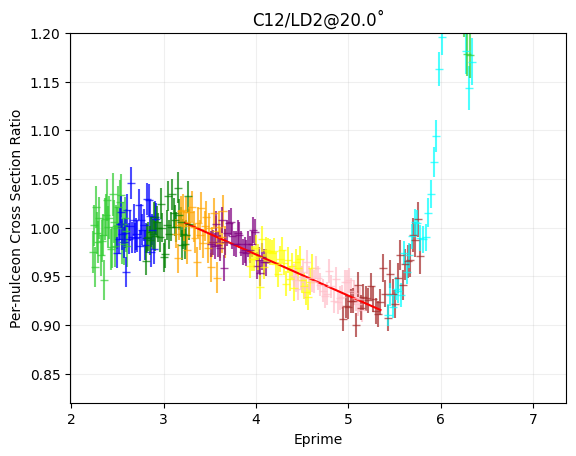

In [216]:
nA = target_info[ntg][1]
nZ = target_info[ntg][0]
dA = target_info[dtg][1]

sf = nA / dA
print("Per-nucleon scaling factor:", sf)

csr_2p42 = born_cross_2p42_ntg / born_cross_2p42_dtg / sf
csr_2p71 = born_cross_2p71_ntg / born_cross_2p71_dtg / sf
csr_3p04 = born_cross_3p04_ntg / born_cross_3p04_dtg / sf
csr_3p4 = born_cross_3p4_ntg / born_cross_3p4_dtg / sf
csr_3p81 = born_cross_3p81_ntg / born_cross_3p81_dtg / sf
csr_4p27 = born_cross_4p27_ntg / born_cross_4p27_dtg / sf
csr_4p78 = born_cross_4p78_ntg / born_cross_4p78_dtg / sf
csr_5p36 = born_cross_5p36_ntg / born_cross_5p36_dtg / sf
csr_5p878 = born_cross_5p878_ntg / born_cross_5p878_dtg / sf
csr_6p6 = born_cross_6p6_ntg / born_cross_6p6_dtg / sf

csr_errors_2p42 = csr_2p42 * np.sqrt((born_errors_2p42_ntg / born_cross_2p42_ntg)**2 + (born_errors_2p42_dtg / born_cross_2p42_dtg)**2)
csr_errors_2p71 = csr_2p71 * np.sqrt((born_errors_2p71_ntg / born_cross_2p71_ntg)**2 + (born_errors_2p71_dtg / born_cross_2p71_dtg)**2)
csr_errors_3p04 = csr_3p04 * np.sqrt((born_errors_3p04_ntg / born_cross_3p04_ntg)**2 + (born_errors_3p04_dtg / born_cross_3p04_dtg)**2)
csr_errors_3p4 = csr_3p4 * np.sqrt((born_errors_3p4_ntg / born_cross_3p4_ntg)**2 + (born_errors_3p4_dtg / born_cross_3p4_dtg)**2)
csr_errors_3p81 = csr_3p81 * np.sqrt((born_errors_3p81_ntg / born_cross_3p81_ntg)**2 + (born_errors_3p81_dtg / born_cross_3p81_dtg)**2)
csr_errors_4p27 = csr_4p27 * np.sqrt((born_errors_4p27_ntg / born_cross_4p27_ntg)**2 + (born_errors_4p27_dtg / born_cross_4p27_dtg)**2)
csr_errors_4p78 = csr_4p78 * np.sqrt((born_errors_4p78_ntg / born_cross_4p78_ntg)**2 + (born_errors_4p78_dtg / born_cross_4p78_dtg)**2)
csr_errors_5p36 = csr_5p36 * np.sqrt((born_errors_5p36_ntg / born_cross_5p36_ntg)**2 + (born_errors_5p36_dtg / born_cross_5p36_dtg)**2)
csr_errors_5p878 = csr_5p878 * np.sqrt((born_errors_5p878_ntg / born_cross_5p878_ntg)**2 + (born_errors_5p878_dtg / born_cross_5p878_dtg)**2)
csr_errors_6p6 = csr_6p6 * np.sqrt((born_errors_6p6_ntg / born_cross_6p6_ntg)**2 + (born_errors_6p6_dtg / born_cross_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
ax7.errorbar(binned_eprime_bin_centers_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax7.errorbar(binned_eprime_bin_centers_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax7.errorbar(binned_eprime_bin_centers_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax7.set_xlabel('Eprime')
ax7.set_ylabel('Per-nulceon Cross Section Ratio')
ax7.set_title(f'{ntg}/{dtg}@{dang}˚')
ax7.grid(alpha = 0.2)
ax7.set_ylim(0.82, 1.2)
# ax7.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))

csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
mask = (bin_centers >= 3.23) & (bin_centers <= 5.36) & ~np.isnan(csr)
filtered_csr = csr[mask]
filtered_bin_centers = bin_centers[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("slope", slope)
print("high point", slope * np.max(filtered_bin_centers) + intercept)
print("low point", slope * np.min(filtered_bin_centers) + intercept)
ax7.plot(filtered_bin_centers, slope*filtered_bin_centers + intercept, 'r')
# fig7.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">Converting to Bjorken-x</h1>

absolute value of slope 0.23079677896903805
EMC Ratio at x = 0.3: 1.0007613544725003


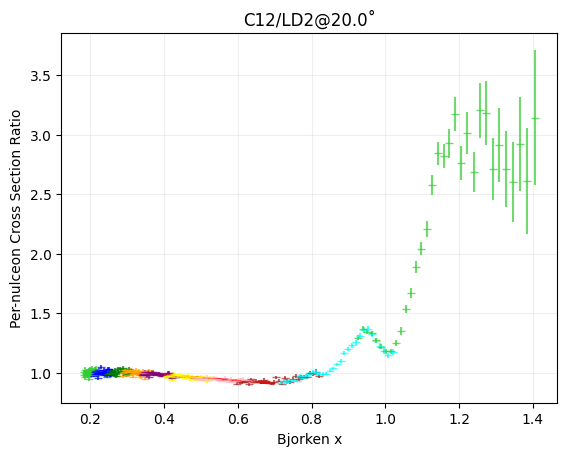

In [217]:
bin_centers_bjx_2p42 = (4 * Ei * binned_eprime_bin_centers_2p42 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p42))
bin_centers_bjx_2p71 = (4 * Ei * binned_eprime_bin_centers_2p71 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p71))
bin_centers_bjx_3p04 = (4 * Ei * binned_eprime_bin_centers_3p04 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p04))
bin_centers_bjx_3p4 = (4 * Ei * binned_eprime_bin_centers_3p4 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p4))
bin_centers_bjx_3p81 = (4 * Ei * binned_eprime_bin_centers_3p81 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p81))
bin_centers_bjx_4p27 = (4 * Ei * binned_eprime_bin_centers_4p27 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p27))
bin_centers_bjx_4p78 = (4 * Ei * binned_eprime_bin_centers_4p78 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p78))
bin_centers_bjx_5p36 = (4 * Ei * binned_eprime_bin_centers_5p36 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p36))
bin_centers_bjx_5p878 = (4 * Ei * binned_eprime_bin_centers_5p878 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p878))
bin_centers_bjx_6p6 = (4 * Ei * binned_eprime_bin_centers_6p6 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_6p6))

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax8.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax8.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('Per-nulceon Cross Section Ratio')
ax8.set_title(f'{ntg}/{dtg}@{dang}˚')
# ax8.set_ylim(0.75, 1.1)
# ax8.set_xlim(0.2, 0.9)
ax8.grid(alpha = 0.2)

bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= 0.3) & (bjx_bin_centers <= 0.7) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]
filtered_csr = csr[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("EMC Ratio at x = 0.3:", slope * np.min(filtered_bin_centers) + intercept)
ax8.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig8.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center"; style="color:lightblue;">Subtracting inelastic contribution from cross-section ratio</h1>

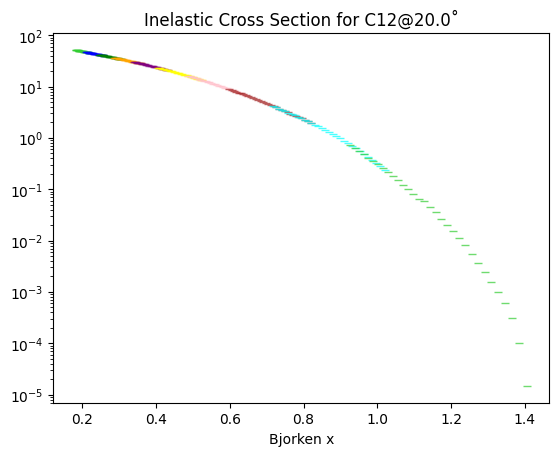

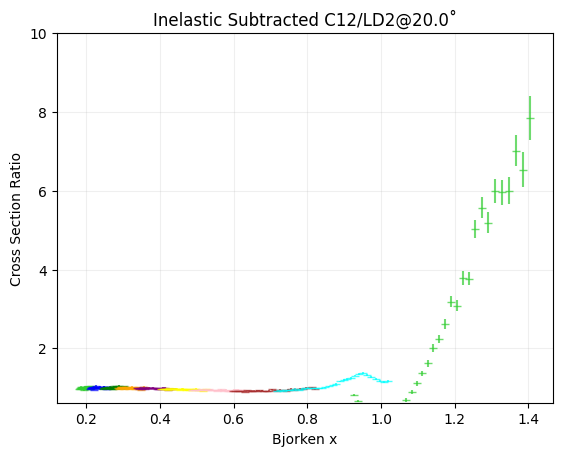

In [218]:
fig, ax = plt.subplots()
ax.errorbar(bin_centers_bjx_2p42, inelastic_array_2p42_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax.errorbar(bin_centers_bjx_2p71, inelastic_array_2p71_ntg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax.errorbar(bin_centers_bjx_3p04, inelastic_array_3p04_ntg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax.errorbar(bin_centers_bjx_3p4, inelastic_array_3p4_ntg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax.errorbar(bin_centers_bjx_3p81, inelastic_array_3p81_ntg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax.errorbar(bin_centers_bjx_4p27, inelastic_array_4p27_ntg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax.errorbar(bin_centers_bjx_4p78, inelastic_array_4p78_ntg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax.errorbar(bin_centers_bjx_5p36, inelastic_array_5p36_ntg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax.errorbar(bin_centers_bjx_5p878, inelastic_array_5p878_ntg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax.errorbar(bin_centers_bjx_6p6, inelastic_array_6p6_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax.set_yscale('log')
ax.set_xlabel('Bjorken x')
ax.set_title(f'Inelastic Cross Section for {ntg}@{dang}˚')

src_6p6_ntg = born_xsec_array_6p6_ntg - inelastic_array_6p6_ntg
src_6p6_dtg = born_xsec_array_6p6 - inelastic_array_6p6_dtg
xsec_6p6_ntg = src_6p6_ntg * fac_6p6_ntg
xsec_6p6_dtg = src_6p6_dtg * ccf_6p6 * ratio_eprime_6p6
csr_src_6p6 = xsec_6p6_ntg / xsec_6p6_dtg / sf

# print("CSR at 6.6 GeV:", csr_6p6)
# print("born cross at 6.6 GeV:", born_xsec_array_6p6_ntg)
# print("inelastic cross at 6.6 GeV:", inelastic_array_6p6_ntg)
# print("src at 6.6 GeV:", src_6p6_ntg)

fig2, ax2 = plt.subplots()
ax2.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax2.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax2.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax2.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax2.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax2.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax2.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax2.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax2.errorbar(bin_centers_bjx_6p6, csr_src_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax2.set_xlabel('Bjorken x')
ax2.set_ylabel('Cross Section Ratio')
ax2.set_title(f'Inelastic Subtracted {ntg}/{dtg}@{dang}˚')
ax2.grid(alpha = 0.2)
ax2.set_ylim(0.62, 10)
fig2.savefig(f'{folder}/csr_src_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

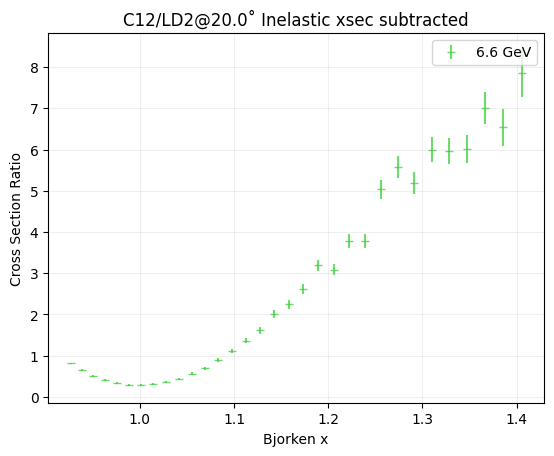

In [219]:
fig, ax = plt.subplots()
ax.errorbar(bin_centers_bjx_6p6, csr_src_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax.set_xlabel('Bjorken x')
ax.set_ylabel(f'Cross Section Ratio')
ax.set_title(f'{ntg}/{dtg}@{dang}˚ Inelastic xsec subtracted')
ax.grid(alpha = 0.2)
ax.legend()
fig.savefig(f'{folder}/inelastic_subtracted_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

Text(0.5, 1.0, 'Inelastic Cross Section for LD2@20.0˚')

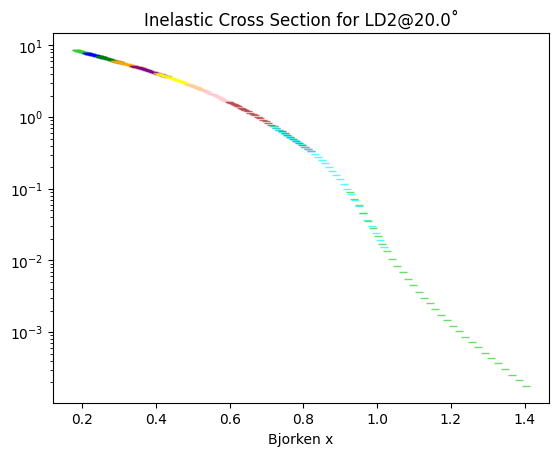

In [220]:
fig, ax = plt.subplots()
ax.errorbar(bin_centers_bjx_2p42, inelastic_array_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax.errorbar(bin_centers_bjx_2p71, inelastic_array_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax.errorbar(bin_centers_bjx_3p04, inelastic_array_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax.errorbar(bin_centers_bjx_3p4, inelastic_array_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax.errorbar(bin_centers_bjx_3p81, inelastic_array_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax.errorbar(bin_centers_bjx_4p27, inelastic_array_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax.errorbar(bin_centers_bjx_4p78, inelastic_array_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax.errorbar(bin_centers_bjx_5p36, inelastic_array_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax.errorbar(bin_centers_bjx_5p878, inelastic_array_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax.errorbar(bin_centers_bjx_6p6, inelastic_array_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax.set_yscale('log')
ax.set_xlabel('Bjorken x')
ax.set_title(f'Inelastic Cross Section for {dtg}@{dang}˚')

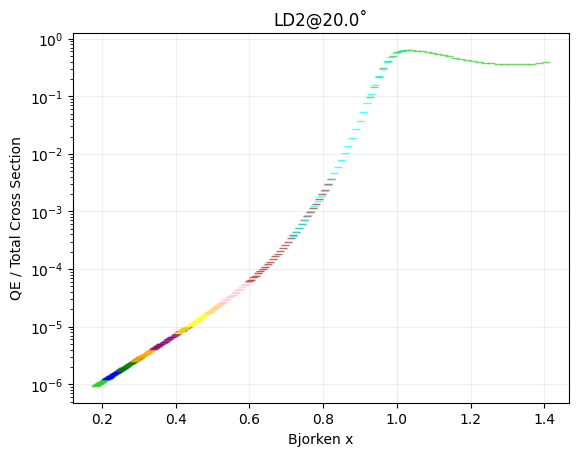

In [221]:
ratio_dtg_2p42 = qe_array_2p42 / born_xsec_array_2p42
ratio_dtg_2p71 = qe_array_2p71 / born_xsec_array_2p71
ratio_dtg_3p04 = qe_array_3p04 / born_xsec_array_3p04
ratio_dtg_3p4 = qe_array_3p4 / born_xsec_array_3p4
ratio_dtg_3p81 = qe_array_3p81 / born_xsec_array_3p81
ratio_dtg_4p27 = qe_array_4p27 / born_xsec_array_4p27
ratio_dtg_4p78 = qe_array_4p78 / born_xsec_array_4p78
ratio_dtg_5p36 = qe_array_5p36 / born_xsec_array_5p36
ratio_dtg_5p878 = qe_array_5p878 / born_xsec_array_5p878
ratio_dtg_6p6 = qe_array_6p6 / born_xsec_array_6p6

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, ratio_dtg_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, ratio_dtg_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, ratio_dtg_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, ratio_dtg_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, ratio_dtg_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, ratio_dtg_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, ratio_dtg_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, ratio_dtg_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax8.errorbar(bin_centers_bjx_5p878, ratio_dtg_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax8.errorbar(bin_centers_bjx_6p6, ratio_dtg_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('QE / Total Cross Section')
ax8.set_title(f'{dtg}@{dang}˚')
ax8.set_yscale('log')
ax8.grid(alpha = 0.2)
fig8.savefig(f'{folder}/model_xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

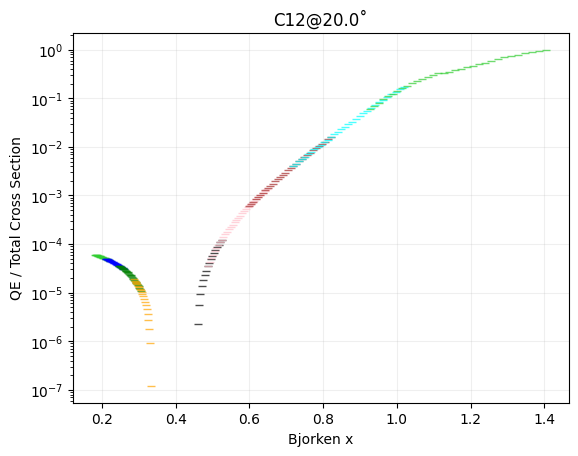

In [222]:
ratio_ntg_2p42 = qe_array_2p42_ntg / born_xsec_array_2p42_ntg
ratio_ntg_2p71 = qe_array_2p71_ntg / born_xsec_array_2p71_ntg
ratio_ntg_3p04 = qe_array_3p04_ntg / born_xsec_array_3p04_ntg
ratio_ntg_3p4 = qe_array_3p4_ntg / born_xsec_array_3p4_ntg
ratio_ntg_3p81 = qe_array_3p81_ntg / born_xsec_array_3p81_ntg
ratio_ntg_4p27 = qe_array_4p27_ntg / born_xsec_array_4p27_ntg
ratio_ntg_4p78 = qe_array_4p78_ntg / born_xsec_array_4p78_ntg
ratio_ntg_5p36 = qe_array_5p36_ntg / born_xsec_array_5p36_ntg
ratio_ntg_5p878 = qe_array_5p878_ntg / born_xsec_array_5p878_ntg
ratio_ntg_6p6 = qe_array_6p6_ntg / born_xsec_array_6p6_ntg


fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, ratio_ntg_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, ratio_ntg_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, ratio_ntg_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, ratio_ntg_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, ratio_ntg_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, ratio_ntg_4p27, fmt = '_', alpha = 0.7, color = 'black', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, ratio_ntg_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, ratio_ntg_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax9.errorbar(bin_centers_bjx_5p878, ratio_ntg_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax9.errorbar(bin_centers_bjx_6p6, ratio_ntg_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax9.set_xlabel('Bjorken x')
ax9.set_ylabel('QE / Total Cross Section')
ax9.set_title(f'{ntg}@{dang}˚')
ax9.set_yscale('log')
ax9.grid(alpha = 0.2)
fig9.savefig(f'{folder}/model_xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

# Calculating isoscalar correction factor

In [223]:
all_eprime_bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
all_bjx = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
isoscalar_all = np.zeros(len(all_eprime_bin_centers))
q2_all = 4 * Ei * all_eprime_bin_centers * (np.sin(dang * np.pi / 180 / 2))**2
print(f"The minimum and maximum Q^2 values are {np.min(q2_all):.2f} and {np.max(q2_all):.2f}")
i = 0

for i in range(len(all_eprime_bin_centers)):
    isoscalar_all[i] = jra_nprat(all_bjx[i], q2_all[i])

print("Average of q2_all", np.mean(q2_all))
print("Average of Bjorken x", np.mean(all_bjx))
print("Length and average of isoscalar_all", len(isoscalar_all), np.mean(isoscalar_all))
# print(isoscalar_all)
# print("csr_2p42", csr_2p42)

The minimum and maximum Q^2 values are 2.84 and 9.04
Average of q2_all 5.37344441814154
Average of Bjorken x 0.5154990242004842
Length and average of isoscalar_all 320 0.5993698323405449


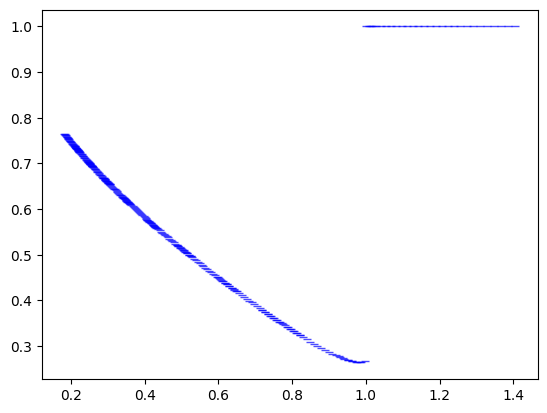

In [224]:
a = plt.plot(all_bjx, isoscalar_all, '_', alpha = 0.7, color = 'blue')

# Calculating and Plotting the final Cross-Section Ratios

nN 6
nZ 6
nA 12
Mean of isoscalar_factor 1.0
absolute value of isoscalar corrected slope 0.23079677896903794
Error on slope 0.010194136905348832
EMC Ratio at x = 0.3: 1.0007613544725003


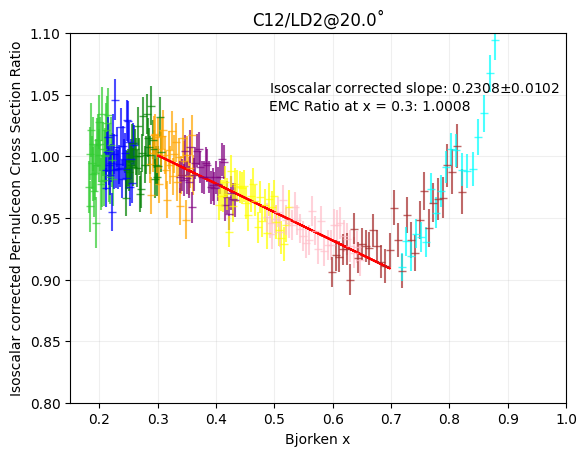

In [225]:
nN = nA - nZ
print("nN", nN)
print("nZ", nZ)
print("nA", nA)
isoscalar_factor = (nA/2 * (1 + isoscalar_all))/(nZ + (nN * isoscalar_all))
isoscalar_factor_2p42 = isoscalar_factor[0:len(binned_eprime_bin_centers_2p42)]
isoscalar_factor_2p71 = isoscalar_factor[len(binned_eprime_bin_centers_2p42):2 * len(binned_eprime_bin_centers_2p71)]
isoscalar_factor_3p04 = isoscalar_factor[2 * len(binned_eprime_bin_centers_2p71):3 * len(binned_eprime_bin_centers_3p04)]
isoscalar_factor_3p4 = isoscalar_factor[3 * len(binned_eprime_bin_centers_3p04):4 * len(binned_eprime_bin_centers_3p4)]
isoscalar_factor_3p81 = isoscalar_factor[4 * len(binned_eprime_bin_centers_3p4):5 * len(binned_eprime_bin_centers_3p81)]
isoscalar_factor_4p27 = isoscalar_factor[5 * len(binned_eprime_bin_centers_3p81):6 * len(binned_eprime_bin_centers_4p27)]
isoscalar_factor_4p78 = isoscalar_factor[6 * len(binned_eprime_bin_centers_4p27):7 * len(binned_eprime_bin_centers_4p78)]
isoscalar_factor_5p36 = isoscalar_factor[7 * len(binned_eprime_bin_centers_4p78):8 * len(binned_eprime_bin_centers_5p36)]
isoscalar_factor_5p878 = isoscalar_factor[8 * len(binned_eprime_bin_centers_5p36):9 * len(binned_eprime_bin_centers_5p878)]
isoscalar_factor_6p6 = isoscalar_factor[9 * len(binned_eprime_bin_centers_5p878):10 * len(binned_eprime_bin_centers_6p6)]
print("Mean of isoscalar_factor", np.mean(isoscalar_factor))

# Apply isoscalar correction to cross-section ratios
iso_csr_2p42 = csr_2p42 * isoscalar_factor_2p42
iso_csr_2p71 = csr_2p71 * isoscalar_factor_2p71
iso_csr_3p04 = csr_3p04 * isoscalar_factor_3p04
iso_csr_3p4 = csr_3p4 * isoscalar_factor_3p4
iso_csr_3p81 = csr_3p81 * isoscalar_factor_3p81
iso_csr_4p27 = csr_4p27 * isoscalar_factor_4p27
iso_csr_4p78 = csr_4p78 * isoscalar_factor_4p78
iso_csr_5p36 = csr_5p36 * isoscalar_factor_5p36
iso_csr_5p878 = csr_5p878 * isoscalar_factor_5p878
iso_csr_6p6 = csr_6p6 * isoscalar_factor_6p6

fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, iso_csr_2p42, yerr = isoscalar_factor_2p42 * csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, iso_csr_2p71, yerr = isoscalar_factor_2p71 * csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, iso_csr_3p04, yerr = isoscalar_factor_3p04 * csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, iso_csr_3p4, yerr = isoscalar_factor_3p4 * csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, iso_csr_3p81, yerr = isoscalar_factor_3p81 * csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, iso_csr_4p27, yerr = isoscalar_factor_4p27 * csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, iso_csr_4p78, yerr = isoscalar_factor_4p78 * csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, iso_csr_5p36, yerr = isoscalar_factor_5p36 * csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax9.errorbar(bin_centers_bjx_5p878, iso_csr_5p878, yerr = isoscalar_factor_5p878 * csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax9.errorbar(bin_centers_bjx_6p6, iso_csr_6p6, yerr = isoscalar_factor_6p6 * csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax9.set_xlabel('Bjorken x')
ax9.set_ylabel('Isoscalar corrected Per-nulceon Cross Section Ratio')
ax9.set_title(f'{ntg}/{dtg}@{dang}˚')
ax9.grid(alpha = 0.2)
# ax9.legend()

iso_csr = np.concatenate((iso_csr_2p42, iso_csr_2p71, iso_csr_3p04, iso_csr_3p4, iso_csr_3p81, iso_csr_4p27, iso_csr_4p78, iso_csr_5p36, iso_csr_5p878, iso_csr_6p6))
filtered_iso_csr = iso_csr[mask]

iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(filtered_bin_centers, filtered_iso_csr)
print("absolute value of isoscalar corrected slope", abs(iso_slope))
norm_3 = iso_slope * np.min(filtered_bin_centers) + iso_intercept
print("Error on slope", iso_std_err)
print("EMC Ratio at x = 0.3:", norm_3)
ax9.plot(filtered_bin_centers, iso_slope * filtered_bin_centers + iso_intercept, 'r')
ax9.set_ylim(0.8, 1.1)
ax9.set_xlim(0.15, 1.0)
ax9.text(0.4, 0.79, f'Isoscalar corrected slope: {abs(iso_slope):.4f}$\pm${iso_std_err:.4f} \nEMC Ratio at x = 0.3: {norm_3:.4f}', transform = ax9.transAxes)
fig9.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

In [226]:
minutes = (time.time() - start_time) / 60
print(f"Time taken: {minutes:.2f} minutes")

Time taken: 2.84 minutes
